In [1]:
import random
import pandas as pd
import numpy as np

## Identifying user retention

For this challenge, we're defining a retained user as one that has logged into the product on three separate days within a seven day period.

To do this, let's import the user engagement table and take a look at the data.

In [2]:
engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
display(engagement.head()); engagement.info()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Everything looks good at first pass. There isn't any missing values, although we need to move the time stamp into a datetime index.

In [4]:
engagement.index = pd.DatetimeIndex(engagement.time_stamp)
# drop time stamp column
engagement.drop(['time_stamp'], axis=1, inplace=True)

In [5]:
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


Next, let's group the dataset by user_id. Then we can do a rolling seven day window and sum the logins.

In [6]:
# column to identify if user was retained
engagement['retained'] = 0

# loop through users
for _, grp in engagement.groupby('user_id'):
    # if user has a total of three logins within a seven day window, record them as retained
    if max(grp.ffill().rolling('7d')['visited'].sum()) == 3:
        engagement.loc[engagement.user_id == int(np.unique(grp.user_id.values)), 'retained'] = 1

Now, let's count the total number of users and how many were qualified as retained.

In [7]:
print(f'Total number of users: {engagement.user_id.unique().shape[0]}')

Total number of users: 8823


In [8]:
print(f'Total number of retained users: {engagement[engagement.retained == 1].user_id.unique().shape[0]}')

Total number of retained users: 305


## Predicting user adoption 

Now that we know which users have been retained, we can build a model to predict future user adoption. First, let's load in the other table that has the features we'll use for our model.

In [9]:
# read in data using the object_id as the index
# note that object_id is the user_id from the other dataframe
users = pd.read_csv('takehome_users.csv', header=0, index_col='object_id', encoding='latin-1')

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 937.5+ KB


In [11]:
users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


Account creation may be useful, but not in its current form. Let's replace the timestamp with its month, as there may be some seasonal variation in user behavior.

In [12]:
users['creation_time'] = pd.to_datetime(users['creation_time'], errors='coerce')

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 937.5+ KB


In [14]:
users['creation_month'] = users['creation_time'].dt.month

The last thing we need to do is to drop all users with null values for the last session creation time. This is the timestamp for the last login, meaning that if there is a null value the user has not logged in.

Note, the column invited by user also has null values, but in this case it is almost half of the dataset. So let's look at a model that drops this column entirely first, then we can evaluate whether it's worth to keep.

In [15]:
users = users.dropna(subset=['last_session_creation_time'])

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
creation_month                8823 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 758.2+ KB


Now, let's get the indices for the train/test splits. We need to do it at the level of the user as we don't want features from the same user in the train and test sets.

In [17]:
# get retained/not retained user ids
retained = list(engagement[engagement.retained == 1].user_id.unique())

In [18]:
# set the labels in users dataframe
users['retained'] = 0
users.loc[retained, 'retained'] = 1

Next, let's select the features and labels from the dataframe.

In [19]:
final_df = pd.get_dummies(users, columns=['creation_source'])
final_df = final_df.drop(['creation_time', 'name', 'email', 'invited_by_user_id', 'last_session_creation_time'], axis=1)

In [20]:
final_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,creation_month,retained,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1,0,11,4,0,1,0,0,0,0
2,0,0,1,11,1,0,1,0,0,0
3,0,0,94,3,0,0,1,0,0,0
4,0,0,1,5,0,1,0,0,0,0
5,0,0,193,1,0,1,0,0,0,0


In [21]:
from sklearn.preprocessing import StandardScaler

# copy data for scaling
scaled = final_df.copy()

continuous = ['org_id', 'creation_month']

# drop categorical variables and scale continuous
scaled[continuous] = StandardScaler().fit_transform(scaled[continuous])

/Users/aidenarnold/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aidenarnold/miniconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
X, y = scaled.drop(['retained'], axis=1).values, scaled.retained.values

In [23]:
# this prevents a bug in XGBoost from causing kernal death
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# this has some custom methods to help with model evaluation
from helper import Model

In [24]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, test_size=0.3, random_state=42)

In [32]:
print(f'The accuracy on the training set is {round(accuracy_score(y_train, rf.predict(X_train)), 3)*100}.')

The accuracy on the training set is 98.8.


In [33]:
print(f'The accuracy on the test set is {round(accuracy_score(y_test, rf.predict(X_test)), 3)*100}.')

The accuracy on the test set is 95.3.


In [54]:
rf = Model(data=(X_train, X_test, y_train, y_test), classifier=RandomForestClassifier(n_estimators=1000, class_weight={0:.1,1:20}))

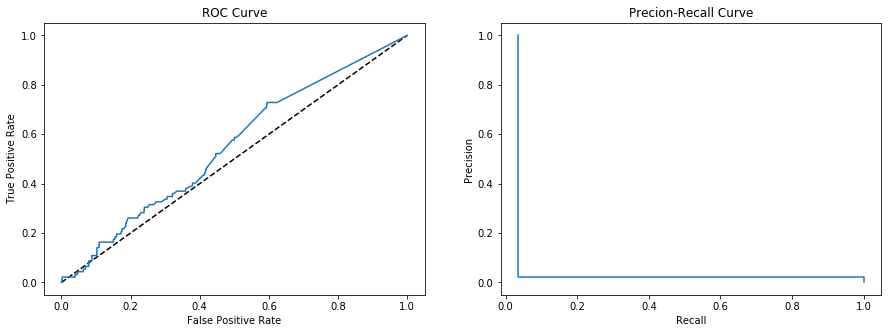

Accuracy on the training data is 0.992.
Accuracy on the test data is 0.945.
The model AUC for ROC curve of the test data is 0.549
Average precision is 0.035.


RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 20},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [55]:
rf.model_performance()

In [31]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([5963,  213]))

As we can see from this output, the classifier is overfitting the majority class as the number of instances far outweight the minority class (adpoted users). One potential solution to this is to weight each class separately, trying to get the classifier to increase the importance of classifying the minority class.

In [56]:
rf_weighted = Model(data=(X_train, X_test, y_train, y_test), classifier=RandomForestClassifier(n_estimators=1000, class_weight={0:.1,1:20}))

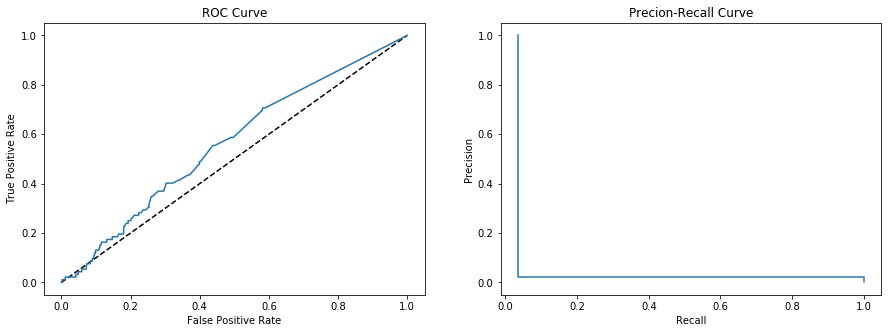

Accuracy on the training data is 0.992.
Accuracy on the test data is 0.945.
The model AUC for ROC curve of the test data is 0.561
Average precision is 0.035.


RandomForestClassifier(bootstrap=True, class_weight={0: 0.1, 1: 20},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [57]:
rf_weighted.model_performance()

Again, we can see from the plots and the precision that weighting the classes didn't help much. Next, let's try using the Synthetic Minority Oversampling Technique (SMOTE) to resample the dataset and create class balance.

In [58]:
from imblearn.over_sampling import SMOTE

In [59]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [61]:
X_res.shape, X.shape

((17036, 9), (8823, 9))

In [62]:
y_res.shape, y.shape

((17036,), (8823,))

We can see that the resampled variables have increased in size. Let's check the class balance.

In [64]:
# split into train and test sets
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res,
                                                    stratify=y_res, test_size=0.3, random_state=42)

In [69]:
np.unique(y_train, return_counts=True), np.unique(y_train_res, return_counts=True)

((array([0, 1]), array([5963,  213])), (array([0, 1]), array([5962, 5963])))

We can see that in the resampled dataset, the minority class has been oversampled to balance it with the majority class. Let's run the classifier again and evaluate performance.

In [65]:
rf = Model(data=(X_train_res, X_test_res, y_train_res, y_test_res), classifier=RandomForestClassifier(n_estimators=1000))

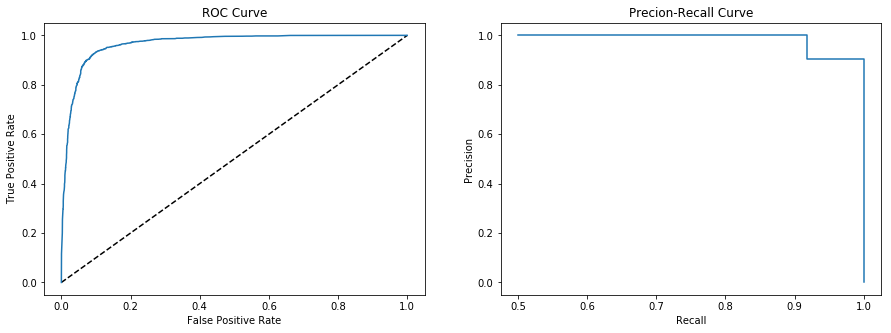

Accuracy on the training data is 0.997.
Accuracy on the test data is 0.912.
The model AUC for ROC curve of the test data is 0.966
Average precision is 0.878.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
rf.model_performance()

Now we are getting much better performance on both classes and our classifier is performing quite well. Last, let's plot the feature importances.

### Feature importance

In [83]:
f_data = {'feature_names' : list(scaled.drop(['retained'], axis=1).columns),
          'feature_importances' : list(rf.fitted_model.feature_importances_)}
imp_df = pd.DataFrame(f_data)

In [86]:
imp_df.sort_values(by='feature_importances', ascending=False)

,feature_names,feature_importances
3,creation_month,0.438469
2,org_id,0.411469
0,opted_in_to_mailing_list,0.046574
1,enabled_for_marketing_drip,0.042353
5,creation_source_ORG_INVITE,0.014496
7,creation_source_SIGNUP,0.013800
8,creation_source_SIGNUP_GOOGLE_AUTH,0.012546
4,creation_source_GUEST_INVITE,0.010623
6,creation_source_PERSONAL_PROJECTS,0.009669


Here, we can see that the month of creation was in fact important to classifying user adoption, indicating that there may be some influence of seasonal variation, or that there was some promotion/change to the product which resulted in changes in user behavior. The organization the user belonged to was also highly ranked, as were the features quantifying user behavior around email lists.

Recommendations from this point are to do a deeper dive into why the creation month was so impactful, and what changes/campaigns were going on in the company that might influence more consistent user adoption. The company should also focus efforts on email campaigns, as they are influential in adopting users.